<a href="https://colab.research.google.com/github/grantrzchan/HTX_Armed_Robberies/blob/master/HTX_Armed_Robberies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [151]:
'''Data for monthly robberies in Houston, Texas, between 2009 and 2020 year-to-date, compiled using Houston Police Department data'''
import pandas as pd
import numpy as np
import seaborn as sns
import math
from sklearn.metrics import mean_squared_error as mse
from math import sqrt
from matplotlib import pyplot as plt

#Register datetime converter for matplotlib to prevent issues with seaborn
pd.plotting.register_matplotlib_converters()

#load data set
data_series = pd.read_csv('./data/HTX_robberies.csv', header=0, index_col=0, parse_dates=True, squeeze=True)

In [152]:
#split data set into model development data set and cross validation set, use year 2019 and 2020 of data as cv
data_end = len(data_series) - 16
data_set, cv_set = data_series[0:data_end], data_series[data_end::]
print(f'Data set: {len(data_set)} months, Validation set: {len(cv_set)} months')

#save training and cv sets to csv format
data_set.to_csv('data_set.csv', header = False)
cv_set.to_csv('cv_set.csv', header = False)

Data set: 114 months, Validation set: 16 months


In [153]:
data_set.describe()

count     114.000000
mean      803.815789
std       114.725495
min       464.000000
25%       723.750000
50%       813.000000
75%       876.750000
max      1087.000000
Name: 982.0, dtype: float64

In [154]:
#create training set and test set
X = data_set.values
X = X.astype('float32')

#start with train set of 80%
train_size = int(0.8*len(X))
train_set, test_set = X[0:train_size], X[train_size::]

In [155]:
#use walk forward validation to create baseline prediction forecast using the persistence model
#create forecast history
historic_obs = [x for x in train_set]
#create baseline predictions
predictions = []
for i in range(len(test_set)):
    #make prediction at t using observation at t-1
    y_hat = historic_obs[-1]
    predictions.append(y_hat)
    #actual t observation from test set
    observation = test_set[i]
    #update historic observations with actual t observation
    historic_obs.append(observation)
    print(f'Predicted: {y_hat: .3f}, Expected: {observation: .3f}')
#report the performance of the forecast using RMSE
rmse = sqrt(mse(test_set, predictions))
print(f'RMSE: {rmse: .3f}')

Predicted:  937.000, Expected:  876.000
Predicted:  876.000, Expected:  760.000
Predicted:  760.000, Expected:  788.000
Predicted:  788.000, Expected:  822.000
Predicted:  822.000, Expected:  763.000
Predicted:  763.000, Expected:  877.000
Predicted:  877.000, Expected:  767.000
Predicted:  767.000, Expected:  580.000
Predicted:  580.000, Expected:  813.000
Predicted:  813.000, Expected:  835.000
Predicted:  835.000, Expected:  960.000
Predicted:  960.000, Expected:  908.000
Predicted:  908.000, Expected:  665.000
Predicted:  665.000, Expected:  721.000
Predicted:  721.000, Expected:  645.000
Predicted:  645.000, Expected:  710.000
Predicted:  710.000, Expected:  766.000
Predicted:  766.000, Expected:  761.000
Predicted:  761.000, Expected:  729.000
Predicted:  729.000, Expected:  659.000
Predicted:  659.000, Expected:  672.000
Predicted:  672.000, Expected:  776.000
Predicted:  776.000, Expected:  813.000
RMSE:  104.130


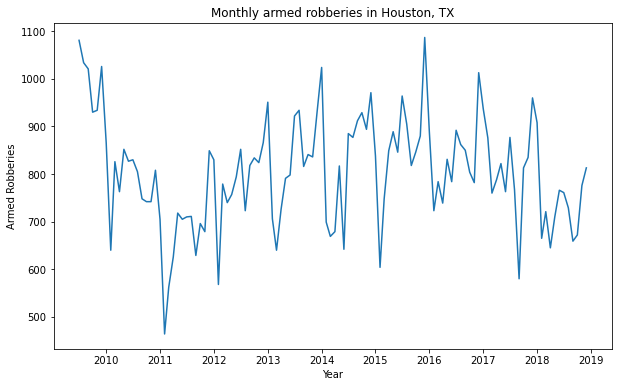

In [156]:
#plot the data
plt.figure(figsize=(10,6))
sns.lineplot(data=data_set)
plt.title('Monthly armed robberies in Houston, TX')
plt.xlabel('Year')
plt.ylabel('Armed Robberies')
plt.show()

### Line plot observations
- The trend for robberies seem to be relatively flat
- There is high variability among data points, which corresponds to the wide spread between the quartile ranges observed above
- The variance between data points seem to be much higher during the initial years between 2009 and 2012, but appears stabilized past 2012.
- The data set is non-stationary, since the data points appears to have changing mean and variance over time for each year. We can plot the mean and variance of the data by year to confirm this. We need a boxplot to better visualize the changes in interquartile range, variance and range.

Text(0, 0.5, 'Variance of armed robberies')

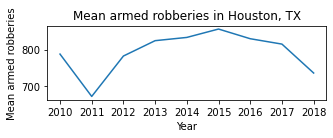

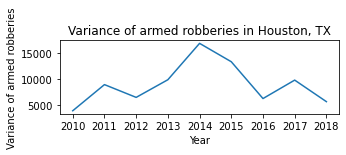

In [157]:
#group data by year for mean, variance and box plot analysis
#2009 only has 6 months of data. We exclude them in the boxplot
grps = data_set['2010':'2018'].groupby(pd.Grouper(freq='A'))
yrs = pd.DataFrame({name.year: grp.values for name, grp in grps})
plt.figure(figsize=(5,3))
plt.figure(1)
plt.subplot(211)
sns.lineplot(data=yrs.mean())
plt.title('Mean armed robberies in Houston, TX')
plt.xlabel('Year')
plt.ylabel('Mean armed robberies')
plt.figure(figsize=(5,3))
plt.figure(2)
plt.subplot(212)
sns.lineplot(data=yrs.var())
plt.title('Variance of armed robberies in Houston, TX')
plt.xlabel('Year')
plt.ylabel('Variance of armed robberies')


### Observations
- Both the mean and variance are changing significantly over time. We need to make the data stationary via differencing before doing a forecast.

- First let's try to normalize the data.

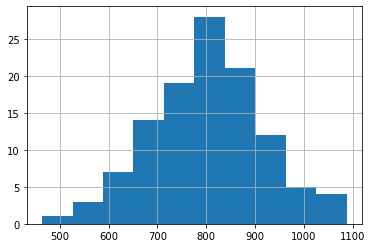

In [158]:
data_set.hist()

In [176]:
#use Box-Cox transform to ensure that data set is completely Gaussian, and check to see if there is any non-Gaussian behavior
from scipy.special import boxcox, inv_boxcox
from statsmodels.graphics.gofplots import qqplot
#turn off verbose warning messages
import warnings
warnings.filterwarnings("ignore")
transformed, lamd = boxcox(data_set)
print(f'Lambda: {lamd: .3f}')

TypeError: ufunc() missing 1 of 2required positional argument(s)

In [160]:
#create a function for inverse Box-Cox transform to revert transformed data back to original units
from math import log
from math import exp
def boxcox_inverse(value, lamb):
    if lamb == 0:
        return exp(value)
    return exp(log(lamb*value + 1)/lamb)

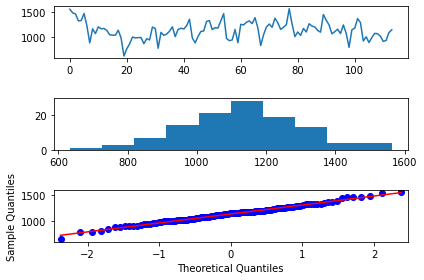

In [161]:
#plot transformed data, histogram and q-q plots
plt.figure()
#plot transformed data
plt.subplot(311)
plt.plot(transformed)
#plot histogram
plt.subplot(312)
plt.hist(transformed)
#plot q-q plot
plt.subplot(313)
qqplot(transformed, line='r', ax=plt.gca())
plt.tight_layout()
plt.show()

In [162]:
def normalizer(data):
    ts_avg, ts_std = data.mean(), data.std()
    normalized = (data - ts_avg)/ts_std
    return normalized, ts_avg, ts_std

def inv_normalizer(normalized, ts_avg, ts_std):
    data = (normalized*ts_std) + ts_avg
    return data

transformed = pd.Series(transformed, index=data_set.index)
normalized_data_set, n_ts_avg, n_ts_std = normalizer(transformed)

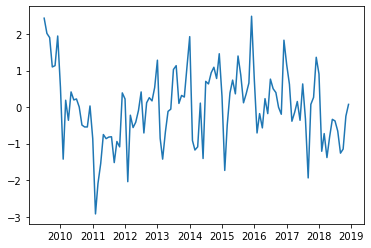

In [163]:
plt.plot(normalized_data_set)

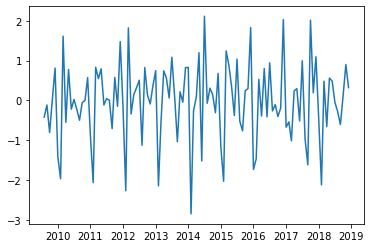

In [164]:
# #Employ first order differencing
# def differencing(data):
#     '''Function executes differencing of order 1 when called'''
#     differenced = [(data[i] - data[i-1]) for i in range(1, len(data))]
#     return differenced

normalized_data_set = normalized_data_set.diff().dropna()
plt.plot(normalized_data_set)

In [165]:
def rm_vol_and_sea(data):
    annual_volatility = data.groupby(data.index.year).std()
    month_avgs = data.groupby(data.index.month).mean()
    data_annual_vol = data.index.map(lambda d: annual_volatility.loc[d.year])
    data_month_avg = data.index.map(lambda d: month_avgs.loc[d.month])
    treated = (data/data_annual_vol) - data_month_avg
    return treated, data_annual_vol, data_month_avg

In [166]:
def add_vol_and_sea(treated, data_annual_vol, data_month_avg):
    data = (treated + data_month_avg) * data_annual_vol
    return data

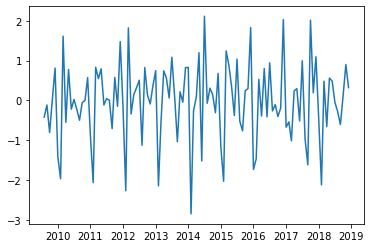

In [167]:
data_set, data_annual_vol, data_month_avg = rm_vol_and_sea(normalized_data_set)
plt.plot(normalized_data_set)

In [168]:
check_stationary(normalized_data_set.values)

ADF Statistic: -3.379
p-value:  0.012
Critical Values:
	1%: -3.498
	5%: -2.891
	10%: -2.582


In [169]:
#create training set and test set
X = normalized_data_set.values
X = X.astype('float32')

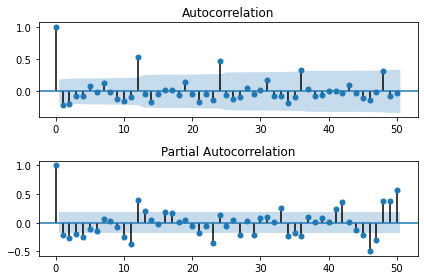

In [170]:
#create ACF and PACF plots to check for autocorrelation
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure()
plt.subplot(211)
plot_acf(X, lags=50, ax=plt.gca())
plt.subplot(212)
plot_pacf(X, lags=50, ax=plt.gca())

#fix any plot overlap with tight layout
plt.tight_layout()
plt.show()

In [171]:
from statsmodels.tsa.arima_model import ARIMA
#create training set and test set
X = normalized_data_set.values
X = X.astype('float32')

In [172]:
#evaluate data set with all possible hyperparameter configurations
p_val = range(0,5)
d_val = range(0,3)
q_val = range(0,5)

#turn off verbose warning messages
import warnings
warnings.filterwarnings("ignore")
evaluate_models(X, p_val, d_val, q_val)

ARIMA(0, 0, 0), RMSE = 0.908
ARIMA(0, 0, 1), RMSE = 0.868
ARIMA(0, 0, 2), RMSE = 0.781
ARIMA(0, 0, 3), RMSE = 0.789
ARIMA(0, 0, 4), RMSE = 0.793
ARIMA(0, 1, 0), RMSE = 1.373
ARIMA(0, 1, 1), RMSE = 0.927
ARIMA(0, 1, 2), RMSE = 0.920
ARIMA(0, 1, 3), RMSE = 0.845
ARIMA(0, 1, 4), RMSE = 0.842
ARIMA(0, 2, 0), RMSE = 2.453
ARIMA(0, 2, 1), RMSE = 1.388
ARIMA(0, 2, 2), RMSE = 0.949
ARIMA(0, 2, 3), RMSE = 0.955
ARIMA(0, 2, 4), RMSE = 0.832
ARIMA(1, 0, 0), RMSE = 0.908
ARIMA(1, 0, 1), RMSE = 0.791
ARIMA(1, 0, 2), RMSE = 0.787
ARIMA(1, 0, 3), RMSE = 0.795
ARIMA(1, 1, 0), RMSE = 1.218
ARIMA(1, 2, 0), RMSE = 1.820
ARIMA(2, 0, 0), RMSE = 0.895
ARIMA(2, 0, 1), RMSE = 0.780
ARIMA(2, 0, 2), RMSE = 0.787
ARIMA(2, 0, 3), RMSE = 0.803
ARIMA(2, 1, 0), RMSE = 1.159
ARIMA(2, 2, 0), RMSE = 1.497
ARIMA(3, 0, 0), RMSE = 0.869
ARIMA(3, 0, 1), RMSE = 0.813
ARIMA(3, 0, 2), RMSE = 0.799
ARIMA(3, 1, 0), RMSE = 1.197
ARIMA(3, 1, 1), RMSE = 0.901
ARIMA(3, 2, 0), RMSE = 1.627
ARIMA(4, 0, 0), RMSE = 0.774
ARIMA(4, 0, 1)

In [178]:
#try the optimal ARIMA(1,0,1) model
X_size = int(0.8*len(X))
train_data_annual_vol, train_data_month_avg = data_annual_vol[0:X_size], data_month_avg[0:X_size]
test_data_annual_vol, test_data_month_avg = data_annual_vol[X_size:], data_month_avg[X_size:]
train_X, test_X = X[0:X_size], X[X_size:]

In [179]:
arima101_hist = [x for x in train_X]
arima101_pred = []
for i in range(len(test_X)):
    # predict
    model = ARIMA(arima101_hist, order=(1,0,1))
    model_fit = model.fit(disp=0)
    arima101_y_hat = model_fit.forecast()[0]
    arima101_pred.append(arima101_y_hat)
    # observation
    obs = test_X[i]
    arima101_hist.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (arima101_y_hat, obs))
# report performance
rmse = sqrt(mse(test_X, arima101_pred))
print(f'RMSE: {rmse: .3f}')

>Predicted=-0.348, Expected=-0.536
>Predicted=-0.058, Expected=-1.013
>Predicted=0.393, Expected=0.244
>Predicted=0.214, Expected=0.297
>Predicted=0.042, Expected=-0.514
>Predicted=0.255, Expected=0.996
>Predicted=-0.235, Expected=-0.961
>Predicted=0.228, Expected=-1.613
>Predicted=0.885, Expected=2.014
>Predicted=-0.167, Expected=0.192
>Predicted=-0.232, Expected=1.098
>Predicted=-0.689, Expected=-0.458
>Predicted=-0.380, Expected=-2.116
>Predicted=0.652, Expected=0.484
>Predicted=0.319, Expected=-0.656
>Predicted=0.558, Expected=0.561
>Predicted=0.208, Expected=0.486
>Predicted=-0.053, Expected=-0.043
>Predicted=-0.034, Expected=-0.278
>Predicted=0.088, Expected=-0.605
>Predicted=0.339, Expected=0.112
>Predicted=0.223, Expected=0.901
>Predicted=-0.230, Expected=0.323
RMSE:  0.791


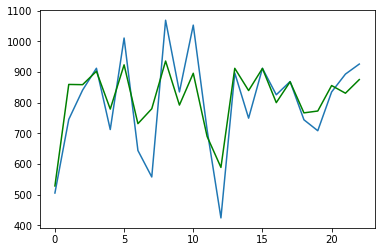

In [180]:
pred_y = [inv_boxcox(inv_normalizer(add_vol_and_sea(arima101_pred[i], test_data_annual_vol[i], test_data_month_avg[i]), 
                                n_ts_avg, n_ts_std), lamd) for i in range(len(test_X))]
y = inv_boxcox(inv_normalizer(add_vol_and_sea(test_X, test_data_annual_vol, test_data_month_avg), n_ts_avg, n_ts_std), lamd)
#plot predictions with actuals
plt.plot(y)
plt.plot(pred_y, color='g')
plt.show()


In [175]:
type(lamd)

numpy.float64

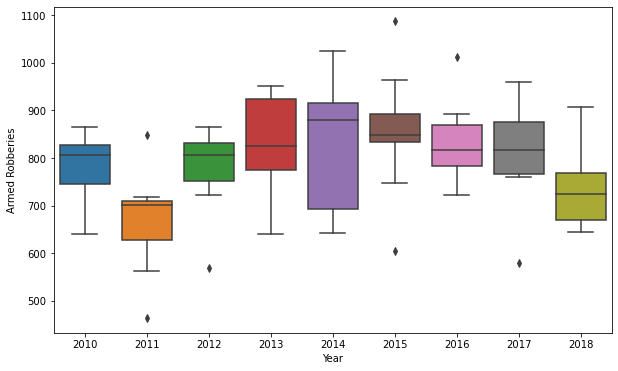

In [8]:
plt.figure(figsize=(10,6))
sns.boxplot(data=yrs)
plt.xlabel('Year')
plt.ylabel('Armed Robberies')
plt.show()

### Box plot observations
- The variance changes over time, but does not appear to do so consistently.
- The median values do not exhibit a linear trend.

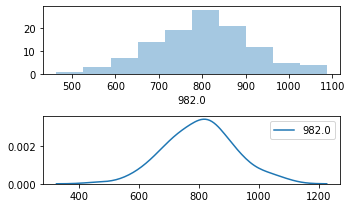

In [9]:
#plot histogram and density plot
plt.figure(figsize=(5,3))
plt.figure(1)
plt.subplot(211)
sns.distplot(data_set, kde=False)
plt.subplot(212)
sns.kdeplot(data_set, shade=False)
plt.tight_layout()
plt.show()

### Histogram and Density plot observations
- The data distribution is largely gaussian
- Transformation functions should still be applied to data set before using it for forecasting


In [19]:
#Implement an ARIMA model to forecast the number of robberies over time
#first check for stationarity of the data set using the augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

def check_stationary(data):
    '''function to check data stationarity using adfuller from statsmodel'''
    result = adfuller(data)
    print(f'ADF Statistic: {result[0]: .3f}')
    print(f'p-value: {result[1]: .3f}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))


#check if stationary using Dickey-Fuller
check_stationary(data_set.values)

ADF Statistic: -1.768
p-value:  0.397
Critical Values:
	1%: -3.498
	5%: -2.891
	10%: -2.582


### Dickey-Fuller Test observation:
- The test statistic value is -1.768 , which is larger than the critical value of -2.891. This indicates that we cannot reject the null hypothesis, which claims that the data is non-stationary, with a significance level of less than 5%. Try employing first order differencing.

In [11]:
#Employ first order differencing
def differencing(data):
    '''Function executes differencing of order 1 when called'''
    differenced = [(data[i] - data[i-1]) for i in range(1, len(data))]
    return differenced

#executing differencing of order 1
stationary_X = differencing(X)

#check if the data is stationary now
check_stationary(stationary_X)

ADF Statistic: -3.369
p-value:  0.012
Critical Values:
	1%: -3.498
	5%: -2.891
	10%: -2.582


- The test statistic value is -3.369, which is smaller than the critical value of -2.891. This indicates that we can reject the null hypothesis, which claims that the data is non-stationary, with a significance level of less than 5%.
- Differencing by order of 1 seems to have made the data set stationary.

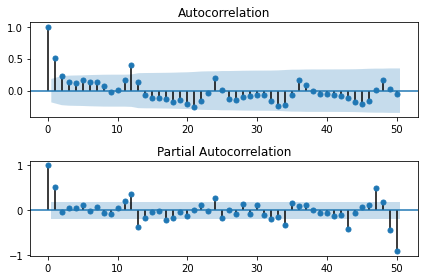

In [12]:
#create ACF and PACF plots to check for autocorrelation
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure()
plt.subplot(211)
plot_acf(X, lags=50, ax=plt.gca())
plt.subplot(212)
plot_pacf(X, lags=50, ax=plt.gca())

#fix any plot overlap with tight layout
plt.tight_layout()
plt.show()

### ACF and PACF plot observations

- The ACF plot shows that lags are significant for the first 2 months.
- The PACF plot shows that lags are significant for likely just 2 months.
- The PACF plot suggests that perhaps the autocorrelations at lag 3 and thereafter are due to the propagation of the autocorrelations at lags 1 and 2.
- The plot suggest an ARMA(2,2) may be used for modelling.
- Since differencing order of the data is 1, an ARIMA(2,1,2) should be a good starting point for modelling the data.

In [27]:
#try an ARIMA model
from statsmodels.tsa.arima_model import ARIMA
arima212_hist = [x for x in train_set]
arima212_pred = []
for i in range(len(test_set)):
    # predict
    model = ARIMA(arima212_hist, order=(2,1,2))
    model_fit = model.fit(disp=0)
    arima212_y_hat = model_fit.forecast()[0]
    arima212_pred.append(arima212_y_hat)
    # observation
    obs = test_set[i]
    arima212_hist.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (arima212_y_hat, obs))
# report performance
rmse = sqrt(mse(test_set, arima212_pred))
print(f'RMSE: {rmse: .3f}')

>Predicted=0.256, Expected=-0.508


ValueError: The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.

### Observations
- A RMSE of 100.54 is too high. Try using a grid search approach to figure out optimal ARIMA (p,d,q) parameters.

In [25]:
#Use Grid Search to find the optimal p,d,q hyperparameters
def evaluate_arima_model(data, arima_order):
    '''Function to evaluate data set X based on ARIMA order with some (p,d,q) and return RMSE'''
    #prepare training data
    data = data.astype('float32')
    train_size = int(len(data) * 0.80)
    train, test = data[0:train_size], data[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mse(test, predictions))
    return rmse

def evaluate_models(data, p_val, d_val, q_val):
    #convert data set to float to prevent numpy error
    data = data.astype('float32')
    best_rmse, best_config = float('inf'), None
    #loop through all values of p,d,q to try every configuration order for ARIMA
    for p in p_val:
        for d in d_val:
            for q in q_val:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(data, order)
                    if rmse < best_rmse:
                        best_rmse, best_config = rmse, order
                    print('ARIMA%s, RMSE = %.3f' % (order, rmse))
                except:
                    continue
    print('Best ARIMA%s, RMSE = %.3f' % (best_config, best_rmse))

In [15]:
#evaluate data set with all possible hyperparameter configurations
p_val = range(0,5)
d_val = range(0,3)
q_val = range(0,5)

#turn off verbose warning messages
import warnings
warnings.filterwarnings("ignore")
evaluate_models(X, p_val, d_val, q_val)

ARIMA(0, 0, 0), RMSE = 104.016
ARIMA(0, 0, 1), RMSE = 96.270
ARIMA(0, 0, 2), RMSE = 95.171
ARIMA(0, 0, 3), RMSE = 95.930
ARIMA(0, 0, 4), RMSE = 97.438
ARIMA(0, 1, 0), RMSE = 111.800
ARIMA(0, 1, 1), RMSE = 105.127
ARIMA(0, 1, 2), RMSE = 98.878
ARIMA(0, 1, 3), RMSE = 99.751
ARIMA(0, 1, 4), RMSE = 100.519
ARIMA(0, 2, 0), RMSE = 174.879
ARIMA(0, 2, 1), RMSE = 113.561
ARIMA(0, 2, 2), RMSE = 109.215
ARIMA(0, 2, 3), RMSE = 105.332
ARIMA(0, 2, 4), RMSE = 104.617
ARIMA(1, 0, 0), RMSE = 95.311
ARIMA(1, 0, 1), RMSE = 96.340
ARIMA(1, 0, 2), RMSE = 96.969
ARIMA(1, 1, 0), RMSE = 109.817
ARIMA(1, 1, 1), RMSE = 98.220
ARIMA(1, 2, 0), RMSE = 151.042
ARIMA(2, 0, 0), RMSE = 95.919
ARIMA(2, 0, 1), RMSE = 95.983
ARIMA(2, 0, 2), RMSE = 97.341
ARIMA(2, 1, 0), RMSE = 108.938
ARIMA(2, 1, 1), RMSE = 99.354
ARIMA(2, 1, 2), RMSE = 100.985
ARIMA(2, 2, 0), RMSE = 143.627
ARIMA(3, 0, 0), RMSE = 97.959
ARIMA(3, 0, 1), RMSE = 97.312
ARIMA(3, 1, 0), RMSE = 106.069
ARIMA(3, 1, 1), RMSE = 101.679
ARIMA(3, 1, 2), RMSE = 1

### Grid Search Results
- The best ARIMA model is an ARIMA(0,0,2) with an RMSE of 95.17

In [16]:
#try the optimal ARIMA(0,0,2) model
from statsmodels.tsa.arima_model import ARIMA
arima002_hist = [x for x in train_set]
arima002_pred = []
for i in range(len(test_set)):
    # predict
    model = ARIMA(arima002_hist, order=(0,0,2))
    model_fit = model.fit(disp=0)
    arima002_y_hat = model_fit.forecast()[0]
    arima002_pred.append(arima002_y_hat)
    # observation
    obs = test_set[i]
    arima002_hist.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (arima002_y_hat, obs))
# report performance
rmse = sqrt(mse(test_set, arima002_pred))
print(f'RMSE: {rmse: .3f}')

>Predicted=747.204, Expected=679.000
>Predicted=751.701, Expected=817.000
>Predicted=821.876, Expected=642.000
>Predicted=698.042, Expected=885.000
>Predicted=853.442, Expected=877.000
>Predicted=842.803, Expected=912.000
>Predicted=837.616, Expected=929.000
>Predicted=863.486, Expected=894.000
>Predicted=836.719, Expected=971.000
>Predicted=884.244, Expected=838.000
>Predicted=808.392, Expected=604.000
>Predicted=675.381, Expected=748.000
>Predicted=798.101, Expected=849.000
>Predicted=840.767, Expected=889.000
>Predicted=837.740, Expected=846.000
>Predicted=815.959, Expected=964.000
>Predicted=890.101, Expected=905.000
>Predicted=844.051, Expected=818.000
>Predicted=793.878, Expected=846.000
>Predicted=830.756, Expected=880.000
>Predicted=845.627, Expected=1087.000
>Predicted=961.592, Expected=891.000
>Predicted=824.695, Expected=723.000
>Predicted=741.078, Expected=784.000
>Predicted=815.937, Expected=739.000
>Predicted=773.689, Expected=831.000
>Predicted=826.875, Expected=784.000


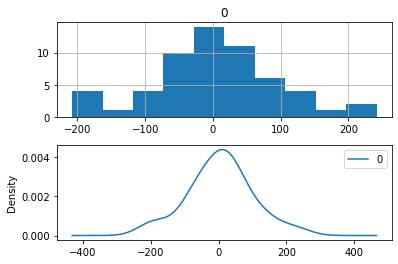

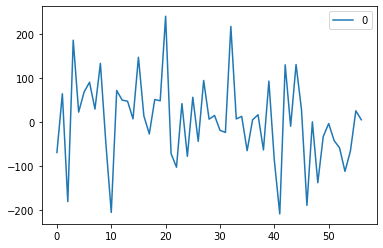

In [17]:
#Check residual errors for other features
#plot residual
residuals = [test_set[i]-arima002_pred[i] for i in range(len(test_set))]
residuals = pd.DataFrame(residuals)
plt.figure()
plt.subplot(211)
residuals.hist(ax=plt.gca())
plt.subplot(212)
residuals.plot(kind='kde', ax=plt.gca())
plt.show()
sns.lineplot(data=residuals)

### Histogram and density plot observations
- Both histogram and density plots for the residuals show a distribution that is Gaussian

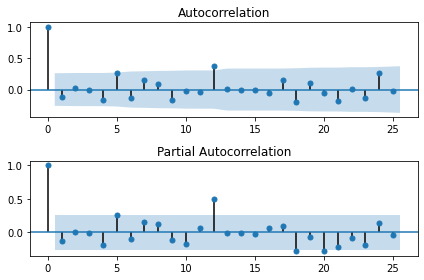

In [18]:
#check ACF and PACF
plt.figure()
plt.subplot(211)
plot_acf(residuals, lags=25, ax=plt.gca())
plt.subplot(212)
plot_pacf(residuals, lags=25, ax=plt.gca())
plt.tight_layout()
plt.show()

### ACF and PACF observations
- Any correlation and partial correlation seems to have been captured.
- There maybe an anomaly at t-12.

In [19]:
#use Box-Cox transform to ensure that data set is completely Gaussian, and check to see if there is any non-Gaussian behavior
from scipy.stats import boxcox
from statsmodels.graphics.gofplots import qqplot
#turn off verbose warning messages
import warnings
warnings.filterwarnings("ignore")
transformed, lamd = boxcox(X)
print(f'Lambda: {lamd: .3f}')

Lambda:  1.059


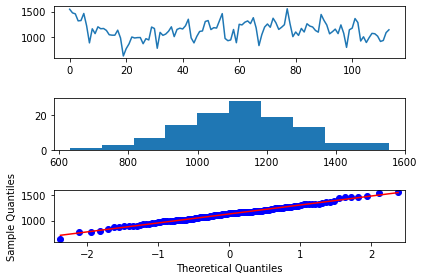

In [20]:
#plot transformed data, histogram and q-q plots
plt.figure()
#plot transformed data
plt.subplot(311)
plt.plot(transformed)
#plot histogram
plt.subplot(312)
plt.hist(transformed)
#plot q-q plot
plt.subplot(313)
qqplot(transformed, line='r', ax=plt.gca())
plt.tight_layout()
plt.show()

### Data transform results
- Transforming the data has reduced the high variability of the data in the earlier years.
- The transformed data has uniform and well-behaved distribution
- The transformed data is close to being perfectly Gaussian

In [21]:
#create a function for inverse Box-Cox transform to revert transformed data back to original units
from math import log
from math import exp
def boxcox_inverse(value, lamb):
    if lamb == 0:
        return exp(value)
    return exp(log(lamb*value + 1)/lamb)

In [22]:
#reevaluate ARIMA(0,0,2) with the box-cox transformed time series
hist_t = [x for x in train_set]
pred_t = []
#predict using transformed data
for i in range(len(test_set)):
    #transform
    tf, lam = boxcox(hist_t)
    #don't do transform if lambda is less than 5
    if lam < -5:
        tf, lam = hist_t, 1
    model = ARIMA(tf, order=(0,0,2))
    model_fit = model.fit(disp=0)
    y_hat_t = model_fit.forecast()[0]
    #invert transformed prediction
    y_hat_t = boxcox_inverse(y_hat_t, lam)
    pred_t.append(y_hat_t)
    #observation
    obs_t = test_set[i]
    hist_t.append(obs_t)
    print('>Predicted=%.3f, Expected=%.3f' % (y_hat_t, obs_t))
# report performance
rmse = sqrt(mse(test_set, pred_t))
print(f'RMSE: {rmse: .3f}')
##finalize model and save 
# monkey patch around bug in ARIMA class
# def __getnewargs__(self):
#     return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))
# ARIMA.__getnewargs__ = __getnewargs__
model_fit.save('model_arima002.pkl')
np.save('model_lambda.npy',[lam])

>Predicted=745.132, Expected=679.000
>Predicted=750.474, Expected=817.000
>Predicted=820.958, Expected=642.000
>Predicted=697.408, Expected=885.000
>Predicted=851.094, Expected=877.000
>Predicted=842.218, Expected=912.000
>Predicted=837.030, Expected=929.000
>Predicted=863.475, Expected=894.000
>Predicted=837.074, Expected=971.000
>Predicted=885.536, Expected=838.000
>Predicted=808.754, Expected=604.000
>Predicted=675.742, Expected=748.000
>Predicted=798.615, Expected=849.000
>Predicted=841.277, Expected=889.000
>Predicted=839.095, Expected=846.000
>Predicted=816.910, Expected=964.000
>Predicted=893.110, Expected=905.000
>Predicted=845.666, Expected=818.000
>Predicted=794.667, Expected=846.000
>Predicted=833.307, Expected=880.000
>Predicted=848.187, Expected=1087.000
>Predicted=966.013, Expected=891.000
>Predicted=824.981, Expected=723.000
>Predicted=741.390, Expected=784.000
>Predicted=817.456, Expected=739.000
>Predicted=774.138, Expected=831.000
>Predicted=828.013, Expected=784.000


### Observations
- Running the ARIMA(0,0,2) model on the transformed data set gave only a slightly loewr RMSE of 95.16.

In [23]:
# finalize model and save to file with workaround
# transform data, use entire data set X now to train the model
import numpy
from statsmodels.tsa.arima_model import ARIMAResults
transformed, lam = boxcox(X)
# fit model
model = ARIMA(transformed, order=(3,0,2))
model_fit = model.fit(disp=0)
# save model
model_fit.save('model_arima002.pkl')
numpy.save('model_lambda.npy', [lam])

In [24]:
# # load the finalized model and make a prediction
model_fit = ARIMAResults.load('model_arima002.pkl')
lam = np.load('model_lambda.npy')
yhat = model_fit.forecast()[0]
yhat = boxcox_inverse(yhat, lam)
print(f'Predicted:{yhat: .3f}')
print(f'Actual value in CV set:{cv_set[0]: .3f}')
print(f'RMSE is {sqrt((cv_set[0]-yhat)**2): .3f}')

Predicted: 817.079
Actual value in CV set: 764.000
RMSE is  53.079


- Predicted value could be better. Compared to the target value in the cross validation set, the predicted value has an RMSE of 53.51

>Predicted=813.830, Expected=764.000
>Predicted=779.744, Expected=564.000
>Predicted=677.235, Expected=660.000
>Predicted=751.039, Expected=727.000
>Predicted=785.319, Expected=864.000
>Predicted=839.911, Expected=754.000
>Predicted=771.292, Expected=837.000
>Predicted=818.686, Expected=822.000
>Predicted=817.347, Expected=713.000
>Predicted=746.223, Expected=732.000
>Predicted=772.034, Expected=863.000
>Predicted=846.696, Expected=900.000
>Predicted=848.478, Expected=910.000
>Predicted=847.173, Expected=721.000
>Predicted=746.702, Expected=681.000
>Predicted=740.577, Expected=456.000
RMSE:  110.401


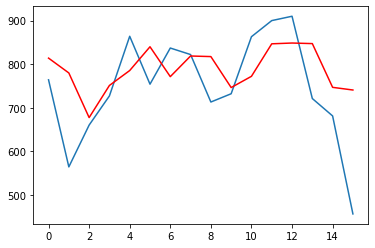

In [25]:
#use cross validation set to test how well the model can make predictions on out-of-sample data
#load CV set as target outputs
y = cv_set.values.astype('float32')
#load model and boxcox lambda
model_fit = ARIMAResults.load('model_arima002.pkl')
lamb = np.load('model_lambda.npy')
#create expanding window forecast, with all subsequent target outputs added to history
hist = [x for x in X]
pred = []
#make predictions
for i in range(len(y)):
    tf, lam = boxcox(hist)
    if lam < -5:
        tf, lam = hist, 1
    model = ARIMA(tf, order=(0,0,2))
    model_fit = model.fit(disp=False)
    yhat = model_fit.forecast()[0]
    #inverse transformed prediction
    yhat = boxcox_inverse(yhat, lam)
    pred.append(yhat)
    obs = y[i]
    hist.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
#report performance
rmse = sqrt(mse(y, pred))
print(f'RMSE: {rmse: .3f}')
#plot predictions with actuals
plt.plot(y)
plt.plot(pred, color='r')
plt.show()

>Predicted=813.830, Expected=764.000
>Predicted=779.697, Expected=564.000
>Predicted=685.287, Expected=660.000
>Predicted=751.736, Expected=727.000
>Predicted=778.684, Expected=864.000
>Predicted=834.343, Expected=754.000
>Predicted=772.021, Expected=837.000
>Predicted=809.938, Expected=822.000
>Predicted=809.348, Expected=713.000
>Predicted=745.948, Expected=732.000
>Predicted=769.641, Expected=863.000
>Predicted=836.402, Expected=900.000
>Predicted=839.930, Expected=910.000
>Predicted=840.311, Expected=721.000
>Predicted=743.624, Expected=681.000
>Predicted=741.404, Expected=456.000
RMSE:  110.431


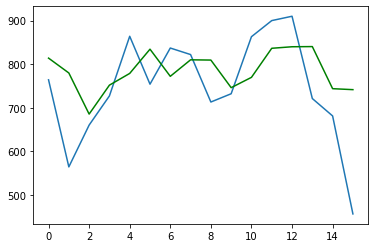

In [26]:
#try rolling window forecast, with all subsequent target outputs added to history
hist = [x for x in X]
pred = []
#make predictions
for i in range(len(y)):
    tf, lam = boxcox(hist[i:])
    if lam < -5:
        tf, lam = hist[i:], 1
    model = ARIMA(tf, order=(0,0,2))
    model_fit = model.fit(disp=False)
    yhat = model_fit.forecast()[0]
    #inverse transformed prediction
    yhat = boxcox_inverse(yhat, lam)
    pred.append(yhat)
    obs = y[i]
    hist.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
#report performance
rmse = sqrt(mse(y, pred))
print(f'RMSE: {rmse: .3f}')
#plot predictions with actuals
plt.plot(y)
plt.plot(pred, color='g')
plt.show()

### Prediction results:
- Differences between expanding window and rolling window forecasts are minimal, with an RMSE difference of around 0.03.
- Perhaps ARIMA model should be fine tuned, with (p,d,q) reselected to fit the transformed data set 

In [27]:
#evaluate transformed data set with all possible hyperparameter configurations
p_val = range(0,5)
d_val = range(0,3)
q_val = range(0,5)

#turn off verbose warning messages
import warnings
warnings.filterwarnings("ignore")
evaluate_models(transformed, p_val, d_val, q_val)

ARIMA(0, 0, 0), RMSE = 154.836
ARIMA(0, 0, 1), RMSE = 143.281
ARIMA(0, 0, 2), RMSE = 141.646
ARIMA(0, 0, 3), RMSE = 142.784
ARIMA(0, 0, 4), RMSE = 145.057
ARIMA(0, 1, 0), RMSE = 166.363
ARIMA(0, 1, 1), RMSE = 156.531
ARIMA(0, 1, 2), RMSE = 147.200
ARIMA(0, 1, 3), RMSE = 148.531
ARIMA(0, 1, 4), RMSE = 149.695
ARIMA(0, 2, 0), RMSE = 260.104
ARIMA(0, 2, 1), RMSE = 168.987
ARIMA(0, 2, 2), RMSE = 162.627
ARIMA(0, 2, 3), RMSE = 155.538
ARIMA(0, 2, 4), RMSE = 155.765
ARIMA(1, 0, 0), RMSE = 141.875
ARIMA(1, 0, 1), RMSE = 143.415
ARIMA(1, 0, 2), RMSE = 144.356
ARIMA(1, 1, 0), RMSE = 163.460
ARIMA(1, 1, 1), RMSE = 146.227
ARIMA(1, 2, 0), RMSE = 224.815
ARIMA(2, 0, 0), RMSE = 142.779
ARIMA(2, 0, 1), RMSE = 142.887
ARIMA(2, 0, 2), RMSE = 144.928
ARIMA(2, 1, 0), RMSE = 162.162
ARIMA(2, 1, 1), RMSE = 147.928
ARIMA(2, 1, 2), RMSE = 149.793
ARIMA(2, 2, 0), RMSE = 213.836
ARIMA(3, 0, 0), RMSE = 145.856
ARIMA(3, 0, 1), RMSE = 144.888
ARIMA(3, 1, 0), RMSE = 157.890
ARIMA(3, 1, 1), RMSE = 151.413
ARIMA(3,

### Observations

- Even with the transformed training set, the optimal ARIMA model is still ARIMA(0,0,2)
- ARIMA may not be sufficient to effectively model the time series. The results are no better than the persistence forecast, which has an RMSE of 110.9.
- Try more sophisticated methods, such as an LSTM RNN model

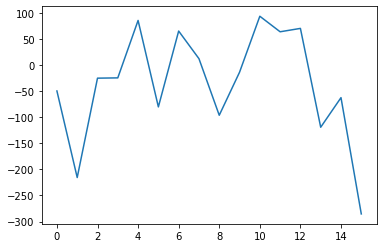

In [28]:
resid = y - pred
plt.plot(resid)
plt.show()

In [30]:
pd.DataFrame(resid).describe()

,0
count,16.000000
mean,-36.509056
std,107.639729
min,-285.404353
25%,-84.344377
50%,-25.011639
75%,63.943040
max,93.358668
